In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator  

In [2]:
data_path = "/kaggle/input/generaldataset/conversionABC.csv"
df = pd.read_csv(data_path, delimiter=',') 
df.head(5)

,IsConversion,ActivationDate,Group,ConversionDate
0,0,2022-01-01,Group_A,NaN
1,0,2022-01-01,Group_A,NaN
2,0,2022-01-01,Group_A,NaN
3,0,2022-01-01,Group_A,NaN
4,0,2022-01-03,Group_A,NaN


In [3]:
# Convert string columns to datetime
df['ActivationDate'] = pd.to_datetime(df['ActivationDate'])
df['ConversionDate'] = pd.to_datetime(df['ConversionDate'])

# Calculate the delta of days between Date2 and Date1
df['DeltaDays'] = (df['ConversionDate'] - df['ActivationDate']).dt.days

df.head(5)

,IsConversion,ActivationDate,Group,ConversionDate,DeltaDays
0,0,2022-01-01,Group_A,NaT,NaN
1,0,2022-01-01,Group_A,NaT,NaN
2,0,2022-01-01,Group_A,NaT,NaN
3,0,2022-01-01,Group_A,NaT,NaN
4,0,2022-01-03,Group_A,NaT,NaN


In [4]:
df.head(5)

,IsConversion,ActivationDate,Group,ConversionDate,DeltaDays
0,0,2022-01-01,Group_A,NaT,NaN
1,0,2022-01-01,Group_A,NaT,NaN
2,0,2022-01-01,Group_A,NaT,NaN
3,0,2022-01-01,Group_A,NaT,NaN
4,0,2022-01-03,Group_A,NaT,NaN


In [5]:
def create_scurve_result(df):
    row_cnt = 0
    columns = ['X','Conv_Total','IsConversion']
    df_new = pd.DataFrame(columns=columns)
    total_rows = len(df.index)
    
    for i in range (0,60):
        found = df.loc[(df['DeltaDays'] == i)]
        row_cnt = (len(found.index) + row_cnt) 
        
        if total_rows > 0:
            conv_running = (row_cnt / total_rows) 
        else:
            conv_running=0
        
        df_new.loc[i] = [i,conv_running,(len(found.index))]
    
    return df_new

In [6]:
DF1 = df[df['Group']=='Group_A']
DF1_R = create_scurve_result(DF1)
DF1_R = DF1_R.drop(columns=['IsConversion'])
DF1_R['Group'] = 'Group_A'
DF1_R = DF1_R.rename(index=str,columns={"DayNumber":"X","Conv_Total":"Y"})

DF2 = df[df['Group']=='Group_B']
DF2_R = create_scurve_result(DF2)
DF2_R = DF2_R.drop(columns=['IsConversion'])
DF2_R['Group'] = 'Group_B'
DF2_R = DF2_R.rename(index=str,columns={"DayNumber":"X","Conv_Total":"Y"})

In [7]:
fin_df = pd.concat([DF1_R, DF2_R], ignore_index=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


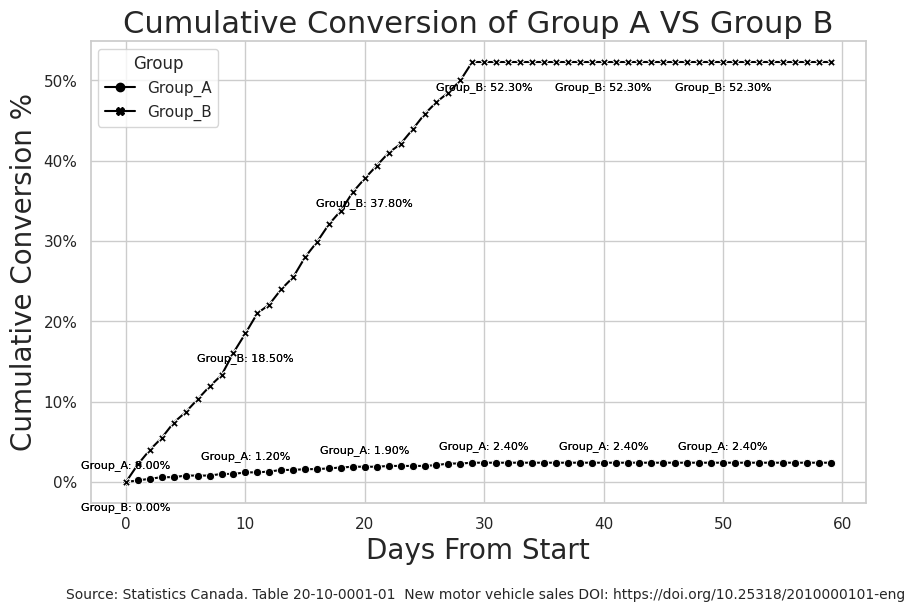

In [8]:
sns.set(style="whitegrid", font_scale=1)

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6),frameon =False)

# Plot the bar chart on the primary y-axis
#line = sns.lineplot(data=fin_df, x="X", y="Y", hue="Group")

# Plot the line chart on the primary y-axis with black color and dots
line = sns.lineplot(data=fin_df, x="X", y="Y", hue="Group", palette={'Group_A': 'black', 'Group_B': 'black'}, markers=True, style="Group", dashes=False)

#Set x-axis label and title
ax.set_xlabel('Days From Start', fontsize=20)
ax.set_ylabel('Cumulative Conversion %', fontsize=20)
ax.set_title('Cumulative Conversion of Group A VS Group B', fontsize=22)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

# Add x-axis grid lines every 10 values
ax.xaxis.set_major_locator(MultipleLocator(10))

# Create legend with proxy artists
#legend_labels = ['Units', 'Dollars (x 1,000)']
#legend_elements = [Patch(facecolor='steelblue', label='Bar Plot'),Line2D([0], [0], color='darkorange', label='Line Plot')]
#plt.legend(handles=legend_elements, labels=legend_labels)

# Add annotations for 'Group_A' and 'Group_B' every 10 ticks
for index, value in enumerate(fin_df['X']):
    if index % 10 == 0:
        group_a_value = fin_df.loc[(fin_df['X'] == value) & (fin_df['Group'] == 'Group_A'), 'Y'].values[0]
        group_b_value = fin_df.loc[(fin_df['X'] == value) & (fin_df['Group'] == 'Group_B'), 'Y'].values[0]
        
        # Format the values as percentages
        group_a_percentage = group_a_value * 100
        group_b_percentage = group_b_value * 100

        # Annotate with formatted percentages
        ax.annotate(f'Group_A: {group_a_percentage:.2f}%', (value, group_a_value), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, color='black')
        ax.annotate(f'Group_B: {group_b_percentage:.2f}%', (value, group_b_value), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=8, color='black')


# Disable the background grid lines
#ax.grid(False)

# Adding a footnote below the x-axis
footnote_text = "Source: Statistics Canada. Table 20-10-0001-01  New motor vehicle sales DOI: https://doi.org/10.25318/2010000101-eng"
plt.figtext(0.1, -0.05, footnote_text, ha="left", fontsize=10, bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))    

# Show the plot
plt.savefig("graph2.png",transparent=True,bbox_inches='tight',pad_inches=0.05,dpi=400) 
plt.show()

In [9]:
"""
final_df = DM_TEST_Trials_df[DM_TEST_Trials_df['eom_ta'] == '2023-10-31']

# Axis 1
y1 = final_df[['GroupType','trialisconversion']].groupby('GroupType').mean()*100

x = y1.index.tolist()
y1 = y1['trialisconversion']

sns.set(style="whitegrid", font_scale=1)

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(4, 5),frameon =False)

# Plot the bar chart on the primary y-axis
bar = sns.barplot(x=x, y=y1, ax=ax1, color='darkorange')
bar = sns.barplot(x=x, y=y1, ax=ax1, color='black')
ax1.set_ylabel('Conversion Rate', color='black', fontsize=20)
ax1.set_ylim([0, 9])
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

# Add values on top of the bars
for i, v in enumerate(y1):
    ax1.annotate(f'{v:,.1f}', xy=(i, v), xytext=(1, 1), ha='center', textcoords='offset points',bbox=dict(boxstyle='round,pad=0.2', edgecolor='black', facecolor='white'),fontsize=20) 

plt.xticks(rotation=0) 

# Set x-axis label and title
ax1.set_xlabel('', fontsize=20)
ax1.set_title('Phase 1 - New & Used', fontsize=20)

# Disable the background grid lines
ax1.grid(False)
ax1.grid(False)

# Adding a footnote below the x-axis
footnote_text = "-130bps"
plt.figtext(0.40, 0.8, footnote_text, ha="left", fontsize=20, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),color='red')    

# Show the plot
plt.savefig("NoDM_overall.png",transparent=True,bbox_inches='tight',pad_inches=0.05,dpi=400) 
plt.show()
"""

'\nfinal_df = DM_TEST_Trials_df[DM_TEST_Trials_df[\'eom_ta\'] == \'2023-10-31\']\n\n# Axis 1\ny1 = final_df[[\'GroupType\',\'trialisconversion\']].groupby(\'GroupType\').mean()*100\n\nx = y1.index.tolist()\ny1 = y1[\'trialisconversion\']\n\nsns.set(style="whitegrid", font_scale=1)\n\n# Create figure and axes\nfig, ax1 = plt.subplots(figsize=(4, 5),frameon =False)\n\n# Plot the bar chart on the primary y-axis\nbar = sns.barplot(x=x, y=y1, ax=ax1, color=\'darkorange\')\nbar = sns.barplot(x=x, y=y1, ax=ax1, color=\'black\')\nax1.set_ylabel(\'Conversion Rate\', color=\'black\', fontsize=20)\nax1.set_ylim([0, 9])\nax1.yaxis.set_major_formatter(mtick.PercentFormatter())\n\n# Add values on top of the bars\nfor i, v in enumerate(y1):\n    ax1.annotate(f\'{v:,.1f}\', xy=(i, v), xytext=(1, 1), ha=\'center\', textcoords=\'offset points\',bbox=dict(boxstyle=\'round,pad=0.2\', edgecolor=\'black\', facecolor=\'white\'),fontsize=20) \n\nplt.xticks(rotation=0) \n\n# Set x-axis label and title\nax1.set